# REVIEWER 
### Combines A & C trials into single regressor
### Accounts for last three noisy volumes in Lvl 1 analysis (FSL ROI -- ExtractROI)
### Comparing HPC activation between Fixed --> Cond w/o BL and BL between Fixed and Cond

## Compares activation for regions of interest using binarized masks:
### Hippocampus (FS labels: hippocampus [17, 53])

## Import all mask and cope files

In [16]:
import os
from glob import glob
import nibabel as nb
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import pearsonr
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette('muted')


sids = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006', 
        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012', 
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',  
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']

proj_dir = '/home/data/madlab/data/mri/wmaze'
 
mask_filenames = []
cope_files = []

for SID in sids:
    #import masks
    mask_filenames_glob = glob(proj_dir + '/roi_analysis/MRthesis/fb4c_2/mask/anat_masks/_subject_id_' + SID + '/_*/*')
    mask_filenames_glob.sort() #sort masks to ensure indices are consistent across subs
    mask_filenames.append(mask_filenames_glob)
    #import 2nd level copes    
    subjcopes_glob = glob(proj_dir + '/scndlvl/wmaze_MRthesis/fixed_before_conditional/REVIEWER/'
                          + SID + '/fixedfx/cope_*')
    subjcopes_glob.sort()
    cope_files.append(subjcopes_glob)
    #test to make sure copes exist
    if len(cope_files[-1]) == 0:
        print(SID)

## Cell to double-check the array indexing

In [17]:
#change first index of cope_files to indicate participant index in sids array
for i, curr_mask in enumerate(mask_filenames[0]):
    print(i, mask_filenames[0][i].split('/')[-1][:-7])

(0, 'lh-all_mPFC_warped')
(1, 'lh-dmPFC_warped')
(2, 'lh-hippocampus_warped')
(3, 'lh-mPFC_fs-3reg_warped')
(4, 'lh-mPFC_fs_warped')
(5, 'lh-mPFC_lausanne_warped')
(6, 'lh-motor_warped')
(7, 'lh_caudate_anat_mask_warped')
(8, 'rh_caudate_anat_mask_warped')
(9, 'rh-all_mPFC_warped')
(10, 'rh-dmPFC_warped')
(11, 'rh-hippocampus_warped')
(12, 'rh-mPFC_fs-3reg_warped')
(13, 'rh-mPFC_fs_warped')
(14, 'rh-mPFC_lausanne_warped')
(15, 'rh-motor_warped')
(16, 'lh-putamen_warped')
(17, 'rh-putamen_warped')
(18, 'all_mPFC_warped_maths')


In [18]:
for i, curr_cope in enumerate(cope_files[0]):
    print(i, cope_files[0][i].split('/')[-1][5:-7]) 

(0, 'AllVsBase')
(1, 'F_C_corr')
(2, 'F_C_incorr')
(3, 'all_remaining')
(4, 'f_BL_C')


## Use binarized mask to obtain activation in ROIs

In [47]:
all_data = {'hp_FC_corr':[], 'hp_FC_incorr':[], 'hp_FBLC':[], 'mpfc_FC_corr':[], 'mpfc_FC_incorr':[], 'mpfc_FBLC':[]}
   
for i in range(len(sids)): #for each subject, load regional mask 
    lh_hp_img = nb.load(mask_filenames[i][2])
    rh_hp_img = nb.load(mask_filenames[i][11])
    mpfc_img = nb.load(mask_filenames[i][18])
    
    FC_corr_img = nb.load(cope_files[i][1]) #load whole brain 2nd level copes
    FC_incorr_img = nb.load(cope_files[i][2])
    FBLC_img = nb.load(cope_files[i][4])

    
    for t in ['FC_corr', 'FC_incorr', 'FBLC']: #for each cope type
        lh_data = eval('{0}_img.get_data()[lh_hp_img.get_data() > 0.]'.format(t)) #get left HPC activation within cope           
        rh_data = eval('{0}_img.get_data()[rh_hp_img.get_data() > 0.]'.format(t)) #get right HPC activation within cope
        bihemi_data = np.concatenate((lh_data, rh_data)) #concatenate both hemispheres into one mask
        all_data['hp_{0}'.format(t)].append(bihemi_data) #append to appropriate dictionary key
        
    for t in ['FC_corr', 'FC_incorr', 'FBLC']: #for each cope type
        data = eval('{0}_img.get_data()[mpfc_img.get_data() > 0.]'.format(t))   #get mPFC activation within cope          
        all_data['mpfc_{0}'.format(t)].append(data) #append to appropriate dictionary key   
                        
all_data_df = pd.DataFrame(all_data) #convert dictionary into Pandas dataframe

In [48]:
all_data_df

,hp_FBLC,hp_FC_corr,hp_FC_incorr,mpfc_FBLC,mpfc_FC_corr,mpfc_FC_incorr
0,"[1.54047, -0.871068, 24.2309, 5.72122, 15.308,...","[1.04515, 2.0519, 13.9935, 6.05359, 22.1433, 1...","[-6.80345, -6.32467, 10.2219, -2.40238, 12.590...","[-1.9326, 0.915402, -3.00791, -3.84305, 2.6149...","[-1.6357, 7.52912, -0.81008, -0.907154, 3.6606...","[-5.47154, 9.4773, -0.59416, 3.40415, -4.48494..."
1,"[-22.6921, 3.62833, -2.78901, 14.376, 0.789429...","[-3.95141, 7.89175, 0.614214, 9.93459, 6.02499...","[-21.4568, 10.5528, -2.77801, 15.1352, -0.0482...","[-0.484282, -10.0204, 4.26383, 14.7397, -5.380...","[4.60777, -4.87877, 7.24678, 17.1866, 3.78907,...","[12.6173, -2.9234, 7.25432, 17.9943, 3.07515, ..."
2,"[15.6729, 7.74869, -3.46972, 6.35197, 9.70621,...","[10.1277, 1.87857, -2.13442, 7.84677, 6.6325, ...","[-17.5745, -1.34308, -4.98691, 8.37403, 3.0481...","[-0.807187, 1.64784, 4.66585, 2.50453, -5.0115...","[5.53106, 6.03747, 5.11531, -1.88049, -2.44342...","[5.65258, 10.5461, 3.38319, 7.39753, 2.94973, ..."
3,"[20.5073, 5.8718, 3.36597, 2.76984, 1.92778, 1...","[14.0863, -1.38979, 3.20668, 4.41655, 2.71001,...","[16.8809, -14.575, 6.90277, -2.99612, 8.52497,...","[0.614732, -1.49308, 0.735729, 12.975, -3.1544...","[-5.88118, 0.311856, -4.68387, 13.3371, -1.901...","[-14.7939, -1.19509, -8.94598, 12.6608, -11.89..."
4,"[4.00741, -3.89267, -2.25371, -16.2535, 6.4945...","[1.09885, -3.03144, -1.80881, -13.8295, 5.7593...","[3.66523, 0.0843155, -1.92646, -14.2415, 1.099...","[-6.50124, -12.9138, 1.47856, -28.141, 7.33555...","[-9.09798, -13.2955, -0.375216, -22.4216, 7.43...","[-0.612768, -16.2996, -2.6127, -18.1398, 8.542..."
5,"[10.5069, -4.38988, -10.1045, -11.2914, 14.095...","[0.951082, 3.17016, -2.4675, -9.47505, 9.53098...","[-9.29672, 7.619, -5.087, -3.59732, -1.80437, ...","[17.7014, -5.59996, -5.9109, -29.8996, 19.6704...","[10.8254, -1.70934, -5.01979, -21.9939, 31.433...","[10.0762, -11.318, -3.37776, -41.8248, -27.678..."
6,"[-8.64591, -0.671141, 6.5632, 3.99108, -7.6683...","[-10.5542, -9.89745, -1.7551, 4.81805, -10.998...","[-12.8169, -13.1442, 19.4485, -1.52868, -11.29...","[-4.80621, 0.628071, -0.440749, -2.03965, 2.80...","[-4.97016, -6.81469, 3.31576, 1.19459, 3.64666...","[-6.28873, 2.63892, 8.21202, 1.37548, 8.57584,..."
7,"[5.87913, 20.9651, 24.4802, 0.221959, 13.6989,...","[6.35162, 18.2625, -0.447262, -0.764554, 5.948...","[-2.67862, 17.3195, -7.80895, -5.51433, -2.508...","[-3.3316, 15.9396, 10.2102, -0.151459, 8.50424...","[-0.0996481, 3.33991, 9.11403, 2.07295, 4.9261...","[3.38687, 14.4913, 6.57092, 8.30114, 11.7279, ..."
8,"[0.981925, -8.06062, 4.92196, 4.81379, 6.68482...","[-2.14479, -8.32317, 5.19606, 1.29016, 3.9582,...","[-7.71217, -13.2644, 2.01894, 3.71384, -0.6441...","[24.8425, -7.33995, -4.19232, -5.69488, -3.938...","[27.2316, -6.97379, -5.06886, -6.85534, 0.0065...","[24.307, -7.7071, -7.04434, -8.9145, -8.61794,..."
9,"[-7.81502, -9.30183, -9.81917, 6.34634, 8.6442...","[-5.85756, -5.41026, -12.4426, -4.31285, -8.72...","[-11.1555, -0.58297, -18.4273, -11.4967, 3.462...","[4.65835, -1.20821, 0.697982, -10.038, -5.4799...","[4.07573, -1.16984, -4.97244, -8.78326, -6.479...","[6.65095, -2.30829, -4.99485, -4.89058, -2.293..."


## Obtain regional activation correlations between fixed before correct conditional and BL interceding fixed before all conditionals

In [49]:
sub_corrs = {'hp':[], 'mpfc':[]}

for i, sub in enumerate(sids):
    for r in ['hp', 'mpfc']:
        x1 = eval('stats.pearsonr(all_data_df["{0}_FC_corr"][{1}], all_data_df["{0}_FBLC"][{1}])[0]'.format(r,i))
        x = 1 - x1
        eval('sub_corrs["{0}"].append(x)'.format(r))
            
sub_corrs_df = pd.DataFrame(sub_corrs)

In [50]:
sub_corrs_df

,hp,mpfc
0,0.237492,0.222422
1,0.127168,0.149083
2,0.111183,0.086060
3,0.290815,0.212549
4,0.176525,0.132985
5,0.118758,0.066082
6,0.183092,0.121791
7,0.295233,0.178109
8,0.308853,0.070293
9,0.300176,0.205329


## Calculate performance for fixed before conditional trials

In [51]:
import os
from os.path import join
from glob import glob
from math import sqrt
import numpy as np
from scipy import stats
import pandas as pd

subs = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006',
        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012',
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']

stim_sets = ['set1', 'set2', 'set3']

count_table = {}
ctstd_table = {}
rt_table = {}
rtstd_table = {}

for sub in subs:
    ct_dict = {}
    rt_dict = {}
    sub_dir = '/home/data/madlab/data/mri/wmaze/scanner_behav/{0}/'.format(sub)
    dir_file = glob(join(sub_dir, '{0}_wmazebl_2015*.txt'.format(sub)))    
    dir_file.sort() 

    for i, curr_set in enumerate(stim_sets):
        run1 = pd.read_table(dir_file[i * 2])
        run2 = pd.read_table(dir_file[i * 2 + 1])
        
        trialtype = np.empty(320, dtype = object)
        trialtype[:160] = run1['TrialType'].values
        trialtype[160:] = run2['TrialType'].values
        
        correct = np.empty(320, dtype = object)
        correct[:160] = run1['Correct'].values
        correct[160:] = run2['Correct'].values
        
        trial_shift1 = trialtype[1:] 
        trial_shift1 = np.append(trial_shift1, -1)
        trial_shift2 = trial_shift1[1:] 
        trial_shift2 = np.append(trial_shift2, -1)       
                
        correct_shift1 = correct[1:] 
        correct_shift1 = np.append(correct_shift1, -1)
        correct_shift2 = correct_shift1[1:] 
        correct_shift2 = np.append(correct_shift2, -1)
       
        FC_corr = np.where(((trialtype == 'A') | (trialtype == 'C'))  & (trial_shift1 == 'B') & (correct_shift1 == 1))[0]        
        FC_incorr = np.where(((trialtype == 'A') | (trialtype == 'C')) & (trial_shift1 == 'B') & (correct_shift1 == 0))[0]
        FBLC = np.where(((trialtype == 'A') | (trialtype == 'C')) & (trial_shift1 == 'BL') & (trial_shift2 == 'B'))[0]
         
        for curr_type in ['FC_corr', 'FC_incorr', 'FBLC']:
            curr_name = '{0}'.format(curr_type)
            if not curr_name in ct_dict:
                ct_dict[curr_name] = []
            ct_dict[curr_name].append(len(eval(curr_name)))                          
    
    for key in ct_dict:
        ct_dict[key] = np.sum(ct_dict[key])
        if not key in count_table:
            count_table[key] = []
        count_table[key].append(ct_dict[key])

BL_df = pd.DataFrame(count_table, index = subs)
BL_df['FC_performance'] = BL_df['FC_corr']/(BL_df['FC_corr']+BL_df['FC_incorr'])

In [52]:
sub_corrs_df['FC_performance'] = list(BL_df['FC_performance'])

In [53]:
sub_corrs_df

,hp,mpfc,FC_performance
0,0.237492,0.222422,0.855491
1,0.127168,0.149083,0.950000
2,0.111183,0.086060,0.838150
3,0.290815,0.212549,0.812834
4,0.176525,0.132985,0.793296
5,0.118758,0.066082,0.752941
6,0.183092,0.121791,0.823864
7,0.295233,0.178109,0.798851
8,0.308853,0.070293,0.574850
9,0.300176,0.205329,0.770588


## Hippocampus

pearsons r (-0.042292938522873157, 0.85947722331542775)


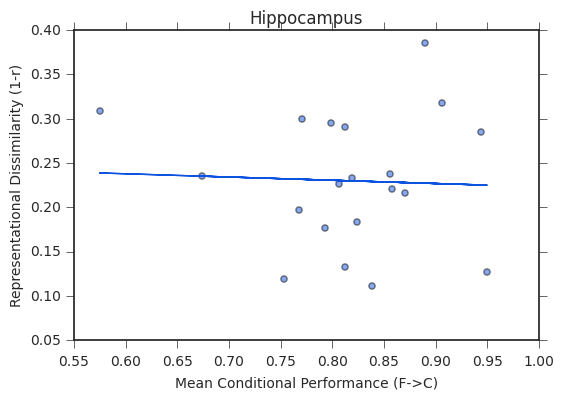

In [54]:
sns.set_style("ticks")

x = BL_df['FC_performance']
y = sub_corrs_df['hp']

fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg = 1)
ax.plot(x, fit[0] * x + fit[1], color = '#0d53e0')
ax.scatter(x, y, c = '#0d53e0', edgecolors = 'black', alpha = 0.5)
ax.set_ylabel('Representational Dissimilarity (1-r)')
ax.set_xlabel('Mean Conditional Performance (F->C)')
ax.set_title('Hippocampus')
ax.set_xlim(0.55, 1)
#ax.set_ylim(-0.1, 0.4)
print "pearsons r", pearsonr(x,y)

HPC (-0.042292938522873157, 0.85947722331542775)


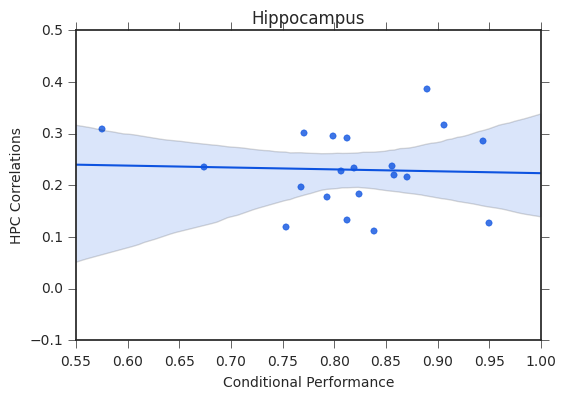

In [59]:
x = sub_corrs_df['FC_performance']
y = sub_corrs_df['hp']

print 'HPC', pearsonr(x,y)
fig, ax = plt.subplots()
ax = sns.regplot(x = 'FC_performance', y = 'hp', color = '#0d53e0', data= sub_corrs_df)
ax.set_xlabel('Conditional Performance')
ax.set_ylabel('HPC Correlations')
ax.set_title('Hippocampus')
ax.set_xlim(0.55, 1)
#ax.set_ylim(-0.1, 0.4)
plt.savefig("/home/arenf001/HPC.png", dpi = 1080)
plt.show()

## mPFC

pearsons r (0.24733894372304885, 0.29309432545542824)


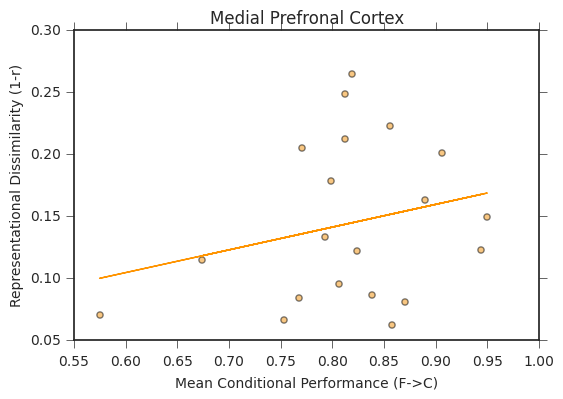

In [56]:
x = BL_df['FC_performance']
y = sub_corrs_df['mpfc']

fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg = 1)
ax.plot(x, fit[0] * x + fit[1], color = '#ff9400')
ax.scatter(x, y, c = '#f29109', edgecolors = 'black', alpha = 0.5)
ax.set_ylabel('Representational Dissimilarity (1-r)')
ax.set_xlabel('Mean Conditional Performance (F->C)')
ax.set_title('Medial Prefronal Cortex')
ax.set_xlim(0.55, 1)
#ax.set_ylim(-0.1, 0.5)
print "pearsons r", pearsonr(x,y)

HPC (0.24733894372304885, 0.29309432545542824)


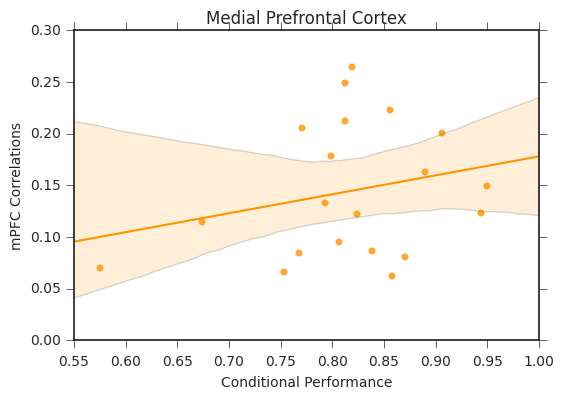

In [58]:
x = sub_corrs_df['FC_performance']
y = sub_corrs_df['mpfc']

print 'HPC', pearsonr(x,y)
fig, ax = plt.subplots()
ax = sns.regplot(x = 'FC_performance', y = 'mpfc', color = '#ff9400', data = sub_corrs_df)
ax.set_xlabel('Conditional Performance')
ax.set_ylabel('mPFC Correlations')
ax.set_title('Medial Prefrontal Cortex')
ax.set_xlim(0.55, 1)
#ax.set_ylim(-0.1, 0.5)
plt.savefig("/home/arenf001/mPFC.png", dpi = 1080)
plt.show()

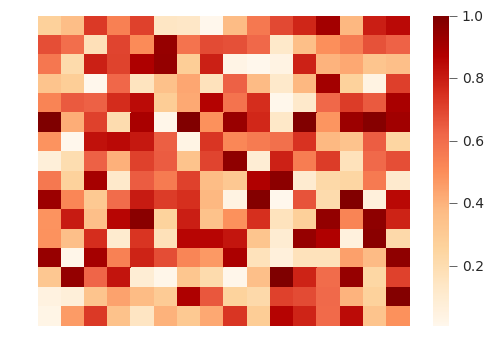

In [30]:
import matplotlib.pyplot as plt
import numpy as np

a = np.random.random((16, 16))
sns.heatmap(a, cmap='OrRd')
plt.axis('off')
plt.savefig('/home/arenf001/sampleheatplot.tif')